In [56]:
#Importing the packages needed to run analyses.
#Pandas, Numpy, Matplotlib and SQLAlchemy are regularly used packages.  If you not have one of these installed, please, open a bash terminal and type: pip.install.<package> where <package> is the package that is not installed.
# Arrow and Seaborn are lesser-used packages, so I have the program install within the environment to finalize the analysis.
try:
    import arrow
except ModuleNotFoundError:
    print("You do not have Arrow installed on your computer.  Let me do that for you.")
    !pip install arrow
    import arrow

try:
    import seaborn as sns
except ModuleNotFoundError:
    print("You do not have Seaborn installed on your computer.  Let me do that for you.")
    !pip install seaborn
    import seaborn as sns

import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates


from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

%matplotlib inline
print("All necessary libraries installed")

#rom matplotlib import style#rom matplotlib import style
#style.use('fivethirtyeight')style.use('fivethirtyeight')


All necessary libraries installed


In [2]:
#This step takes our SQL Database and creates the engine that will drive the database to our dataframes
engine = create_engine("sqlite:///Instructions/Resources/hawaii.sqlite")

You engine is ready to go


In [3]:
#Here we are identifying what are the tables(by proxy, Classes) available to us.

Base = automap_base()
Base.prepare(engine, reflect=True)
keys = Base.classes.keys()
print(f"Here are the keys to the kingdom")
print(*keys, sep=", ")

Here are the keys to the kingdom
measurement, station


In [4]:
#Here we are creating a localized session.
session = Session(engine)

In [5]:
#We are creating the classes based off of the tables avialable to us in the SQL database.
Measurement= Base.classes.measurement
Station = Base.classes.station

## Precipitation Analysis

In [6]:
#let's find the out what are the columns names by calling the dictionary of the class Measurement.
measure_first_row = session.query(Measurement).first()
measure_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x206e3a933c8>,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01'}

In [109]:
#Two queries are done here.  The first is identify what the latest date is in the Measurement table.
#We then want to find out what is the date one year prior to get a range of dates for our second query.
#These two dates are used in the second query to determine results

lastdate = session.query(func.max(Measurement.date)).\
            scalar()
            
a_maxdate = arrow.get(lastdate)
startdate = a_maxdate.shift(months=-12).format('YYYY-MM-DD')

query = session.query(Measurement).\
            filter(Measurement.date.between(startdate,lastdate)).\
            all()

In [26]:
#Assigning values to two lists: dates and precip.
dates = []
precip = []
for row in query:
    measurement = row
    dates.append(measurement.date)
    precip.append(measurement.prcp)

In [27]:
#Creating our DataFrame with dates and precip as our values.
measurement = pd.DataFrame({"date":dates,
                             "precipitation":precip})
measurement.dropna(inplace = True)
measurement

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2223,2017-08-17,0.13
2225,2017-08-19,0.09
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [28]:
#Sets the column 'date' to be the index.  Sorts the data based off the index.
measurement.set_index('date', inplace = True)
measurement.sort_index(inplace=True)
measurement

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


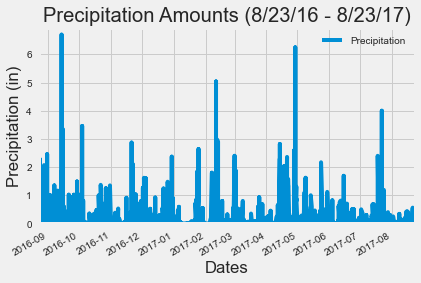

In [61]:
#Overall this will plot what we need for the precipitation analysis.
plt.style.use('fivethirtyeight')

#Setting the variables that populate the chart
date = measurement.index
MDate = mdates.datestr2num(date)
precipitation = measurement['precipitation']


#Setting the date form
months_fmt = mdates.DateFormatter('%M')

#Calling the function subplots
fig, ax = plt.subplots()

#Plotting Precipitation Amounts by date
ax.plot(MDate,precipitation,label = 'Precipitation')

#setting the location of the format of the x-axis ticks.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

#Determining the limits of the x an y axes.
datemin = np.datetime64(date[0])# - np.timedelta64(10,'D')
datemax = np.datetime64(date[-1])# + np.timedelta64(10,'D')
precipmin = precipitation.min()
precipmax = precipitation.max() + .25
ax.set_xlim(datemin,datemax)
ax.set_ylim(precipmin,precipmax)

#Making Sure that we have a grid and a legend.
ax.grid(True)
ax.legend()

#Adding labels and titles
ax.set_title('Precipitation Amounts (8/23/16 - 8/23/17)')
ax.set_ylabel('Precipitation (in)')
ax.set_xlabel('Dates')

#tightening the layout.
plt.tight_layout

#showing the results
plt.show
#Saving the image in png format
plt.savefig('results/precipitation.png')

## Station Analysis

In [87]:
Station.__table__

Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)

In [86]:
#Let's look at the what information is in both Station and Measurement
Measurement.__table__

Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None)

In [69]:
#Getting a count of stations.
station_count = session.query(Station).\
                    distinct().\
                    count()

                    
print(f'There are {station_count} stations.')

There are 9 stations.


In [103]:
by_station_count=session.query(Measurement,
                               Measurement.station,
                               Station.name, 
                               func.count(Measurement.station).label('station_count')).\
                    join(Station, Measurement.station==Station.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).\
                    all()


for row in by_station_count:
    print(f"{row.station_count} observations were made at {row.name}")

2772 observations were made at WAIHEE 837.5, HI US
2724 observations were made at WAIKIKI 717.2, HI US
2709 observations were made at KANEOHE 838.1, HI US
2669 observations were made at WAIMANALO EXPERIMENTAL FARM, HI US
2612 observations were made at MANOA LYON ARBO 785.2, HI US
2202 observations were made at KUALOA RANCH HEADQUARTERS 886.9, HI US
1979 observations were made at HONOLULU OBSERVATORY 702.2, HI US
1372 observations were made at PEARL CITY, HI US
511 observations were made at UPPER WAHIAWA 874.3, HI US


In [106]:
top_station_count=session.query(Measurement,
                               Measurement.station,
                               Station.name, 
                               func.count(Measurement.station).label('station_count')).\
                    join(Station, Measurement.station==Station.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).\
                    first()
print(f"{top_station_count.name} had the most observations at {top_station_count.station_count}")

WAIHEE 837.5, HI US had the most observations at 2772


In [108]:
last12_top_sta_count=session.query(Measurement,
                                   Measurement.station,
                                   Station.name, 
                                   func.count(Measurement.station).label('station_count')).\
                    join(Station, Measurement.station==Station.station).\
                    filter(Measurement.date.between(startdate,lastdate)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).\
                    first()

print(f"{last12_top_sta_count.name} had the most observations in the last 12 months with {last12_top_sta_count.station_count} observations.")

WAIKIKI 717.2, HI US had the most observations in the last 12 months with 361 observations.


In [121]:
subquery = session.query(Station.station).filter(Station.name.like('%WAIKIKI%')).subquery()
waikiki_last_year = session.query(Measurement).\
                    filter(Measurement.station.in_(subquery)).\
                    filter(Measurement.date.between(startdate,lastdate))


In [123]:
tobs = []
for row in waikiki_last_year:
    tobs.append(row.tobs)


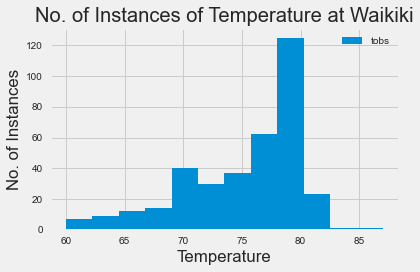

In [159]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

fig,ax = plt.subplots(tight_layout=True, sharey=True)

ax.hist(tobs,bins=12,label='tobs')


ax.set_xlabel('Temperature')
ax.set_ylabel('No. of Instances')
ax.set_title('No. of Instances of Temperature at Waikiki')

ax.legend()

plt.show()